In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#### Preprocecing ###

In [3]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [4]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [5]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [6]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]

In [7]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]

In [8]:
removed = recovered + death

In [9]:
### Data Preparation ###

In [10]:
S = confirmed.values
R = removed.values

In [11]:
data = {'T': S.shape[0], 'N': S.shape[1], 'S': S, 'R': R}

In [12]:
### Model ###

In [13]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7bb6dcc44e91d0621be4d7e15163d949 NOW.


In [14]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [15]:
### Simulation and Visualization functions ###

In [16]:
T = S.shape[0]
N = S.shape[1]

In [209]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    infected_list = []
    for d in range(horizen):
        infected_list.append(cumulative - recovered)
        cumulative0 = cumulative
        I = (cumulative - recovered) @ c * (1 - cumulative / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.maximum(I, 0)
        recovered = recovered + a * (cumulative0 - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.clip(recovered, 0, cumulative)
        
    infected = pd.DataFrame(infected_list, 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected

In [234]:
def draw_infected(fit, start, horizen, country):
    a = fit['a']
    p = fit['p']
    c = fit['c']
    sigma_S = fit['sigma_S']
    sigma_R = fit['sigma_R']
    np.random.shuffle(a)
    np.random.shuffle(p)
    np.random.shuffle(c)
    np.random.shuffle(sigma_S)
    np.random.shuffle(sigma_R)
    data = pd.DataFrame()
    for i in range(10):
        infected = simulate(a[i], p[i], c[i], sigma_S[i], sigma_R[i], start, horizen)
        data = pd.concat([data, infected[country]], axis=1)
    graph = pd.DataFrame({'Real':(confirmed - removed)[country]})
    median = data.median(axis=1)
    upper = data.quantile(q=0.975, axis=1)
    lower = data.quantile(q=0.025, axis=1)
    graph = graph.join(graph, median)
    graph['Upper'] = upper
    graph['Lower'] = lower
    graph['days'] = pd.Series(graph.index - pd.to_datetime('2020-01-22')).apply(lambda x: x.days)
    graph.set_index('days')
    graph= graph.drop('days', axis=1)
    sns.relplot(kind="line", ci='sd', data=graph);

In [235]:
### Validation ###

In [236]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

ValueError: You are trying to merge on float64 and datetime64[ns] columns. If you wish to proceed you should use pd.concat

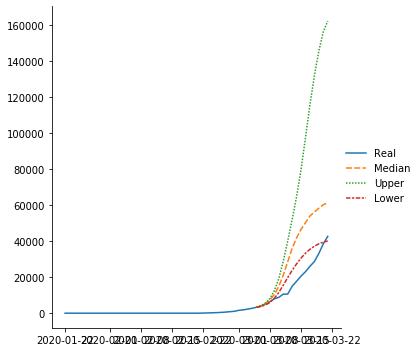

In [216]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

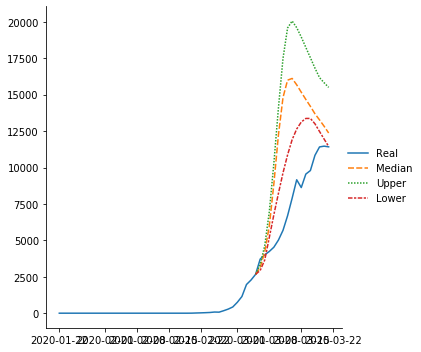

In [217]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

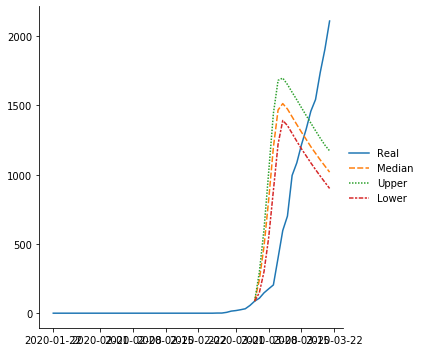

In [218]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

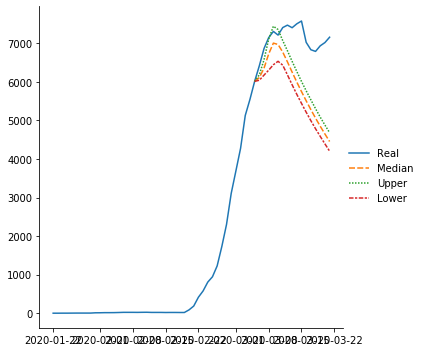

In [219]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

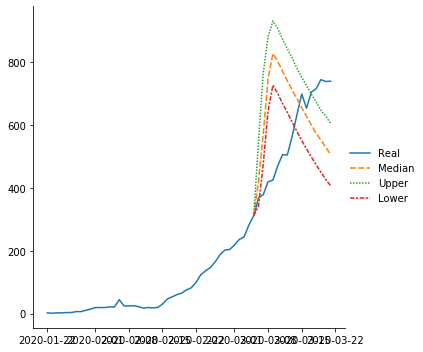

In [220]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

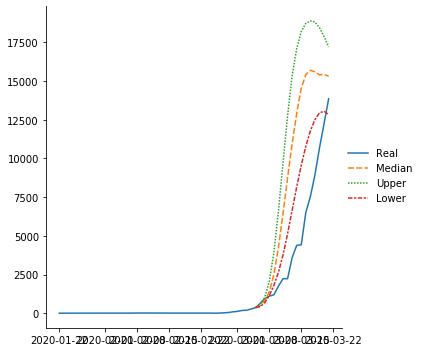

In [221]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

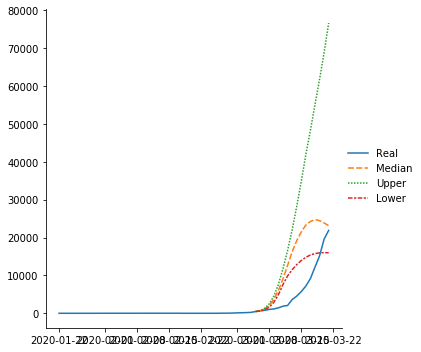

In [222]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

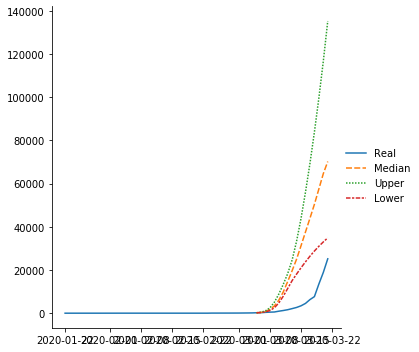

In [223]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [26]:
### Prediction ###

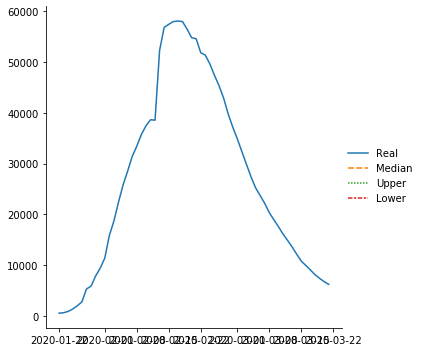

In [224]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'China')

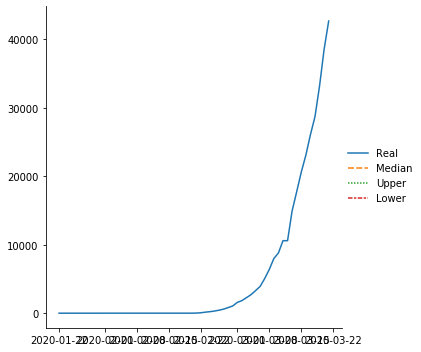

In [225]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Italy')

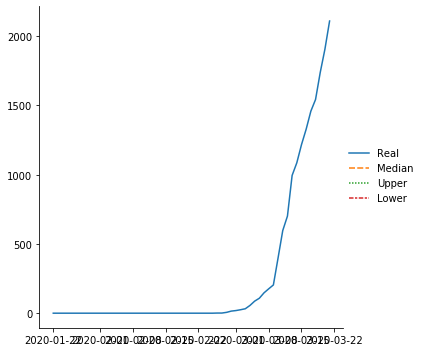

In [226]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Norway')

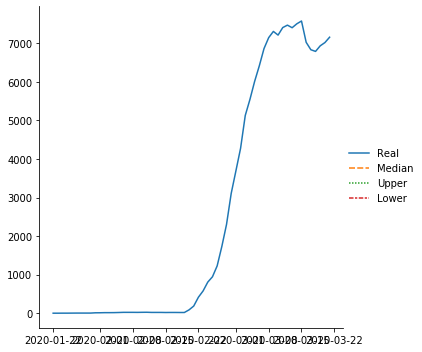

In [227]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Korea, South')

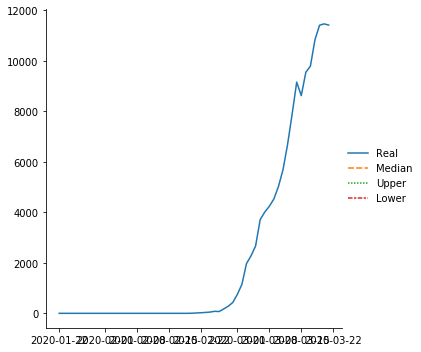

In [228]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Iran')

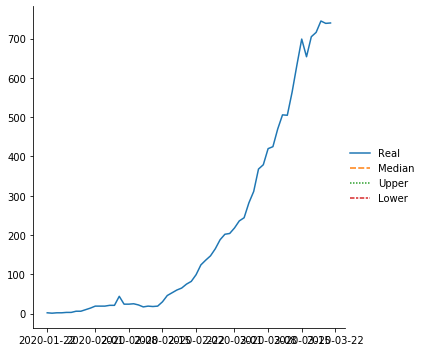

In [229]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Japan')

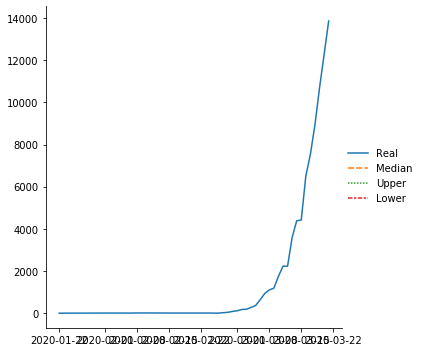

In [230]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'France')

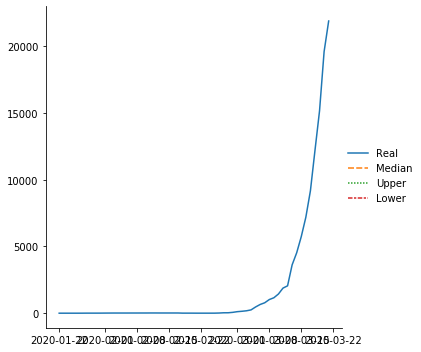

In [231]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Germany')

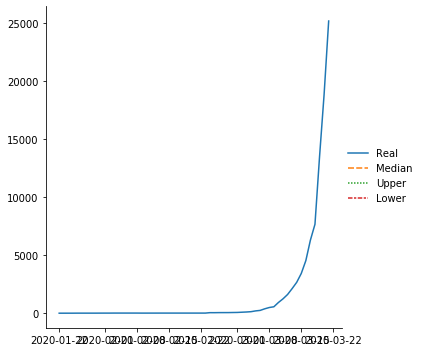

In [232]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'US')